In [2]:
import jax
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import diffeqsolve, ODETerm, Dopri5, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun

#### Stochastic interpolants example (SDE)

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("data_generators"))))
from data_generators import inf_train_gen

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
2024-05-13 23:44:56.219629: W pjrt_plugin/src/mps_client.cc:563] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



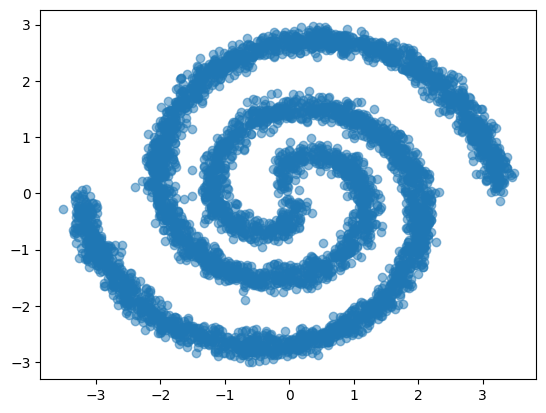

In [4]:
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(5000,2))

plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.5)

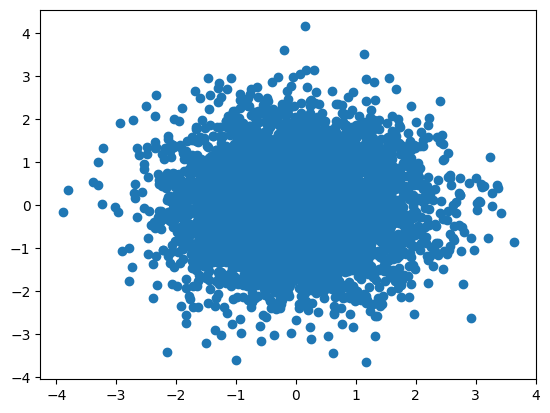

In [5]:
plt.scatter(reference_samples[:,0],reference_samples[:,1])

In [6]:
class NeuralNetwork(eqx.Module):
    layers: list
    extra_bias: jax.Array

    def __init__(self, key):
        key1, key2, key3, key4, key5 = jax.random.split(key, 5)
        # These contain trainable parameters.
        self.layers = [eqx.nn.Linear(3, 512, key=key1),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 512,key=key2),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 512, key=key3),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 512, key=key4),
                       jax.nn.elu,
                       eqx.nn.Linear(512, 2, key=key5)]
        # This is also a trainable parameter.
        self.extra_bias = jax.numpy.zeros(2)

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = (layer(x))
        return self.layers[-1](x) + self.extra_bias
    
def I(t,x,y):
    return jnp.cos(0.5*jnp.pi*t)*x + jnp.sin(0.5*jnp.pi*t)*y

def It(t,x,y):
    return -0.5*jnp.pi*jnp.sin(0.5*jnp.pi*t)*x + 0.5*jnp.pi*jnp.cos(0.5*jnp.pi*t)*y

def gamma(t):
    return jnp.sqrt(2*t*(1-t)+1e-8)

gammadot = vmap(vmap(grad(gamma)))

#CHANGE SHIT HERE!!!!!!!!! WARNING!!!!!!!!

@eqx.filter_jit  # compile this function to make it run fast.
# @eqx.filter_grad  # differentiate all floating-point arrays in `model`.
def loss(b_model, t, x, y, z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    bhat = jax.vmap(b_model)(tx)  # vectorise the model over a batch of data


    bnorm2 = jnp.mean(jnp.sum(bhat**2,axis=1))
    dot_term = jnp.mean(jnp.sum((It(t,x,y) + gammadot(t)*z)*bhat,axis=1))
#     dot_term = 2 * jnp.mean(jnp.sum((It(t,x,y))*bhat,axis=1))
    return bnorm2 - 2*dot_term
    # return jnp.mean((bhat - (It(t,x,y) + gammadot(t)*z))**2)

def loss_denoise(eta_model,t,x,y,z):
    tx = jnp.hstack([t.reshape(-1,1),I(t,x,y)+gamma(t)*z])
    etahat = jax.vmap(eta_model)(tx)  # vectorise the model over a batch of data
    
    etanorm2 = jnp.mean(jnp.sum(etahat**2,axis=1))
    dot_term = jnp.mean(jnp.sum(etahat*z,axis=1))
    return etanorm2 - 2*dot_term

In [7]:
t = jax.random.uniform(jax.random.PRNGKey(3),(num_target,1))
z = jax.random.normal(jax.random.PRNGKey(4),(num_target,2))
model = NeuralNetwork(jax.random.PRNGKey(0))
loss(model,t,reference_samples,target_samples,z)
loss_denoise(model,t,reference_samples,target_samples,z)

Array(0.01580681, dtype=float32)

In [8]:
def evaluate_b(b_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss(b_model,t,x,y,z)
    return avg_loss / 100

In [9]:
def evaluate_eta(eta_model, testloader):
    avg_loss = 0
    for t,x,y,z in testloader:
        avg_loss += loss_denoise(eta_model,t,x,y,z)
    return avg_loss / 100

In [10]:
def self_stack(x):
    return jnp.vstack([x,x])
def get_trainloader(batch_size = 512):
    assert batch_size%2==0
    batch_num = 0
    while True:
        batch_num+=1
        trainloader_key = jax.random.PRNGKey(batch_num//2)
        ref_key,target_key,normal_key,t_key = jax.random.split(trainloader_key,4)
        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))
        t_vals = jax.random.uniform(t_key,(batch_size,1))
        z = jax.random.normal(normal_key,ref_batch.shape)
        yield self_stack(t_vals),self_stack(ref_batch),self_stack(target_batch),jnp.vstack([z,-z])

def get_testloader(batch_size = 1000):
    assert batch_size%2==0
    num_batches = 100
    for i in range(num_batches):
        testloader_key = jax.random.PRNGKey(1000*i)
        ref_key,target_key,normal_key,t_key = jax.random.split(testloader_key,4)

        ref_batch = jax.random.choice(ref_key,reference_samples,(batch_size,))
        target_batch = jax.random.choice(target_key,target_samples,(batch_size,))

        t_vals = jax.random.uniform(t_key,(batch_size,1))

        z = jax.random.normal(normal_key,ref_batch.shape)
        yield self_stack(t_vals),self_stack(ref_batch),self_stack(target_batch),jnp.vstack([z,-z])

In [11]:
def train_b(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_b(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

In [12]:
def train_eta(
  model: NeuralNetwork,
  optim,
  steps,
  train_loader,
  print_every,
)  -> NeuralNetwork:
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    @eqx.filter_jit
    def make_step(
        model,
        opt_state,
        t,
        x,
        y,
        z
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss_denoise)(model,t,x,y,z)
        updates, opt_state = optim.update(grads,opt_state,model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value
    train_losses = []
    
    for step, (t,x,y,z) in zip(range(steps), train_loader):
        model, opt_state, train_loss = make_step(model, opt_state, t,x,y,z)
        train_losses.append(train_loss)
        if jnp.isnan(train_loss):
            print("Nan")
            break
        if (step % print_every) == 0 or (step == steps - 1):
            testloader = get_testloader()
            test_loss = evaluate_eta(model, testloader)
            print("step=" + str(step) + " | train_loss=" + str(train_loss) + " | test_loss= "+ str(test_loss))

    return model,train_losses

# DO NOT RUN THIS CELL UNLESS YOU WANNA WAIT FOREVER!

In [13]:
b_learning_rate = 2e-3

b_optim = optax.chain(
   optax.clip_by_global_norm(1.0),
   optax.adamw(b_learning_rate),
)
b_model = NeuralNetwork(jax.random.PRNGKey(420))
b_trainloader = get_trainloader(batch_size = 2048)

b_model,b_losses = train_b(b_model,b_optim,steps=13000,train_loader=b_trainloader,print_every=1000)

step=0 | train_loss=0.040715426 | test_loss= 1.5291606
step=1000 | train_loss=-2.0712965 | test_loss= -1.8192886
step=2000 | train_loss=-1.8753393 | test_loss= -1.7814747
step=3000 | train_loss=-2.111958 | test_loss= -1.971762
step=4000 | train_loss=-1.7770987 | test_loss= -2.0195491
step=5000 | train_loss=-1.9689546 | test_loss= -1.8885559
step=6000 | train_loss=-2.0256715 | test_loss= -1.860329
step=7000 | train_loss=-2.0174007 | test_loss= -2.0321865
step=8000 | train_loss=-2.2321744 | test_loss= -2.1471002
step=9000 | train_loss=-2.4266398 | test_loss= -2.1657233
step=10000 | train_loss=-2.117424 | test_loss= -2.025348
step=11000 | train_loss=-2.0601163 | test_loss= -2.1263075
step=12000 | train_loss=-2.254605 | test_loss= -2.219636
step=12999 | train_loss=-2.3071895 | test_loss= -2.1560297


In [14]:
eta_learning_rate = 1e-4
eta_trainloader = get_trainloader(batch_size = 2048)

eta_optim = optax.chain(
   optax.clip_by_global_norm(1.0),
   optax.adamw(eta_learning_rate),
)

eta_model = NeuralNetwork(jax.random.PRNGKey(420))
eta_model,eta_losses = train_eta(eta_model,eta_optim,steps=5000,train_loader=eta_trainloader,print_every=1000)

step=0 | train_loss=0.0074604005 | test_loss= -0.13126019
step=1000 | train_loss=-0.331496 | test_loss= -0.36321038
step=2000 | train_loss=-0.37182355 | test_loss= -0.3687123
step=3000 | train_loss=-0.35956872 | test_loss= -0.3741969
step=4000 | train_loss=-0.35201147 | test_loss= -0.37809834
step=4999 | train_loss=-0.3398882 | test_loss= -0.37781203


In [15]:
eps = 0.0
epsilon = lambda t: t*(1-t)*eps 

vmapped_b_model = vmap(b_model)
vmapped_eta_model = vmap(eta_model)
def dX_t(t,x,args):
    t_vec = jnp.ones((len(x),1))*t
    return vmapped_b_model(jnp.hstack([t_vec,x])) - (epsilon(t)/(gamma(t)+1e-12))*vmapped_eta_model(jnp.hstack([t_vec,x]))



# t0, t1 = 0.0, 1.0
# # t_vec = jnp.ones((len(x),1))*t
# # drift = lambda t, x, args: dX_t(t,x)
# diffusion = lambda t, x, args: 2*jnp.sqrt(2*epsilon(t))
# brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-3, shape=(), key=jax.random.PRNGKey(1))
# terms = MultiTerm(ODETerm(dX_t), ControlTerm(diffusion, brownian_motion))
# solver = Heun()
# saveat = SaveAt(dense=True)

# sol = diffeqsolve(terms, solver, t0, t1, dt0=0.005, y0=reference_samples.copy(), saveat=saveat)
# X = sol.evaluate(1.0)
# print(X)  
X0 = reference_samples.copy()
X = X0.copy()
X_hist = []
t = 0
for i in range(100):
    X += 0.01 * dX_t(t,X,None)
    t+=0.01
    X_hist.append(X)

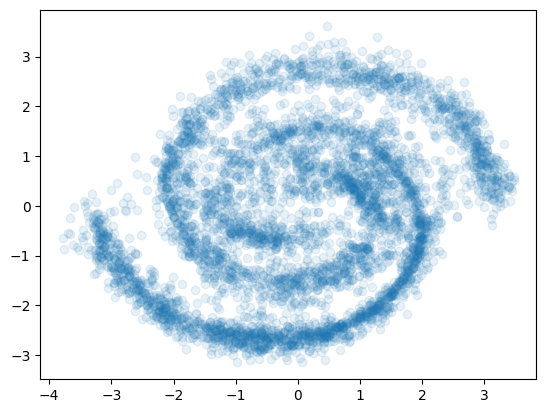

In [16]:
plt.scatter(X[:,0],X[:,1], alpha=0.1)

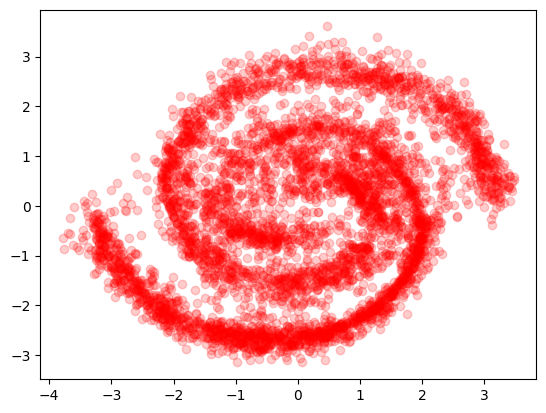

In [17]:
plt.scatter(X[:,0],X[:,1],c='red',alpha = 0.2)

# Make pretty flow plots later

In [120]:
X_hist = jnp.array(X_hist)
plt.scatter(X0[:,0],X0[:,1],c='red',alpha = 0.5)
plt.scatter(X[:,0],X[:,1],c='black',alpha = 0.5)

for i in range(500):
    plt.plot(X_hist[:,i,0],X_hist[:,i,1],c='blue',alpha = 0.05,lw = 5)

NameError: name 'X_hist' is not defined

In [ ]:
term = ODETerm(dX_t)
solver = Dopri5()
X0 = reference_samples
solution = diffeqsolve(term, solver, t0=0, t1=1., dt0=0.01, y0=X0)